In [29]:
import pandas as pd
import seaborn as sb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import sklearn.tree as tree
import matplotlib.pyplot as plt

In [30]:
df_teams=pd.read_csv('data_merged.csv')

df_teams = df_teams[df_teams['year'] != 1]
df_teams.drop(columns=['tmID'], inplace=True)
df_teams.head()


,year,rank,playoff,o_fgm,o_fga,o_ftm,o_fta,o_3pm,o_3pa,o_oreb,...,dq,height,weight,award_count,won,lost,post_wins,post_losses,W,L
0,2,8.0,1,812.0,1903.0,431.0,577.0,131.0,386.0,305.0,...,6.0,71.333333,166.111111,0.0,9.0,23.0,0.0,0.0,0.0,0.0
1,2,2.0,1,809.0,1828.0,426.0,570.0,141.0,407.0,331.0,...,7.0,71.538462,168.538462,0.0,17.0,15.0,3.0,3.0,3.0,3.0
2,2,5.0,0,868.0,1980.0,519.0,699.0,76.0,273.0,341.0,...,2.0,71.857143,166.857143,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,2.0,1,891.0,1894.0,521.0,634.0,172.0,491.0,273.0,...,2.0,72.428571,172.571429,0.0,27.0,5.0,6.0,0.0,6.0,0.0
4,2,7.0,0,796.0,1838.0,428.0,569.0,193.0,521.0,285.0,...,9.0,71.800000,166.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


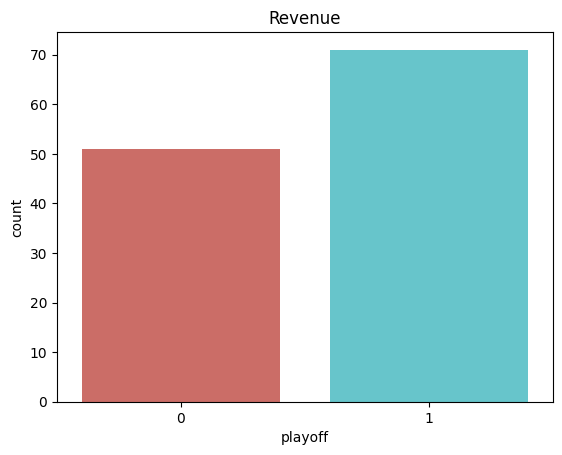

In [31]:
sb.countplot(x='playoff',data=df_teams, palette='hls')
plt.title("Revenue")
plt.show()

In [32]:
from sklearn.decomposition import PCA

def train_evaluate_decision_tree_graph(model, data, target_col="playoff", scaling=False):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    years_tested = []

    # Sort the data by the "year" column
    data = data.sort_values(by="year")

    years = sorted(data["year"].unique())

    for year in years[2:]:
       
        # Split the data into training and test sets
        train_data = data[data["year"] < year ]
        test_data = data[data["year"] == year ]

        if(scaling):
            scaler = MinMaxScaler()
            train_data = scaler.fit_transform(train_data)
            train_data = pd.DataFrame(train_data, columns=data.columns)
            test_data = scaler.transform(test_data)
            test_data = pd.DataFrame(test_data, columns=data.columns)

        X_train = train_data.drop([target_col], axis=1)
        y_train = train_data[target_col]
        X_test = test_data.drop([target_col], axis=1)
        y_test = test_data[target_col]

        
        # Create and train the decision tree model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)
        
        print(y_pred)
        

        # Calculate accuracy and precision
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        years_tested.append(year)

    return years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores


In [33]:

def train_evaluate_decision_tree(model, data, target_col="playoff", scaling=False):
    # Sort the data by the "year" column
    data = data.sort_values(by="year")
       
    # Define the training and testing split ratios
    train_ratio = 0.7
    train_data_year = int(train_ratio * len(data["year"].unique()))

    train_data = data[data["year"] < train_data_year]
    test_data = data[data["year"] >= train_data_year]
    if(scaling):
        scaler = MinMaxScaler()
        train_data = scaler.fit_transform(train_data)
        train_data = pd.DataFrame(train_data, columns=data.columns)
        test_data = scaler.transform(test_data)
        test_data = pd.DataFrame(test_data, columns=data.columns)

    X_train = train_data.drop(target_col, axis=1)
    y_train = train_data[target_col]
    X_test = test_data.drop(target_col, axis=1)
    y_test = test_data[target_col]

    # Create and train the decision tree model
    model.fit(X_train, y_train)
    feature_names = X_train.columns

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy and precision
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

In [34]:
def plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores):
    # Create a graph to plot accuracy, precision, recall, and f1 over time
    plt.figure(figsize=(20, 5))

    # Plot accuracy
    plt.subplot(1, 4, 1)
    plt.plot(years_tested, accuracy_scores, marker='o')
    plt.title('Accuracy Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('Accuracy')

    # Plot precision
    plt.subplot(1, 4, 2)
    plt.plot(years_tested, precision_scores, marker='o', color='orange')
    plt.title('Precision Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('Precision')

    # Plot recall
    plt.subplot(1, 4, 3)
    plt.plot(years_tested, recall_scores, marker='o', color='green')
    plt.title('Recall Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('Recall')

    # Plot f1
    plt.subplot(1, 4, 4)
    plt.plot(years_tested, f1_scores, marker='o', color='red')
    plt.title('F1 Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('F1')

    plt.tight_layout()
    plt.show()



[0 1 1 0 0 1 1 1 0 1 1 1]
[1 1 1 1 0 1 1 0 0 1 1 0 1]
[0 1 1 1 1 1 1 1 0 0 1 1 0]
[1 1 0 1 0 1 0 1 1 1 1 1 0]
[1 0 1 1 1 0 1 1 0 1 1 1 0]
[1 1 1 1 1 1 1 1 0 1 1 0 1]
[1 1 1 0 0 1 1 0 0 0 1 1 0]
Accuracy: 0.7230769230769231
Precision: 0.7037037037037037
Recall: 0.95
F1: 0.8085106382978724


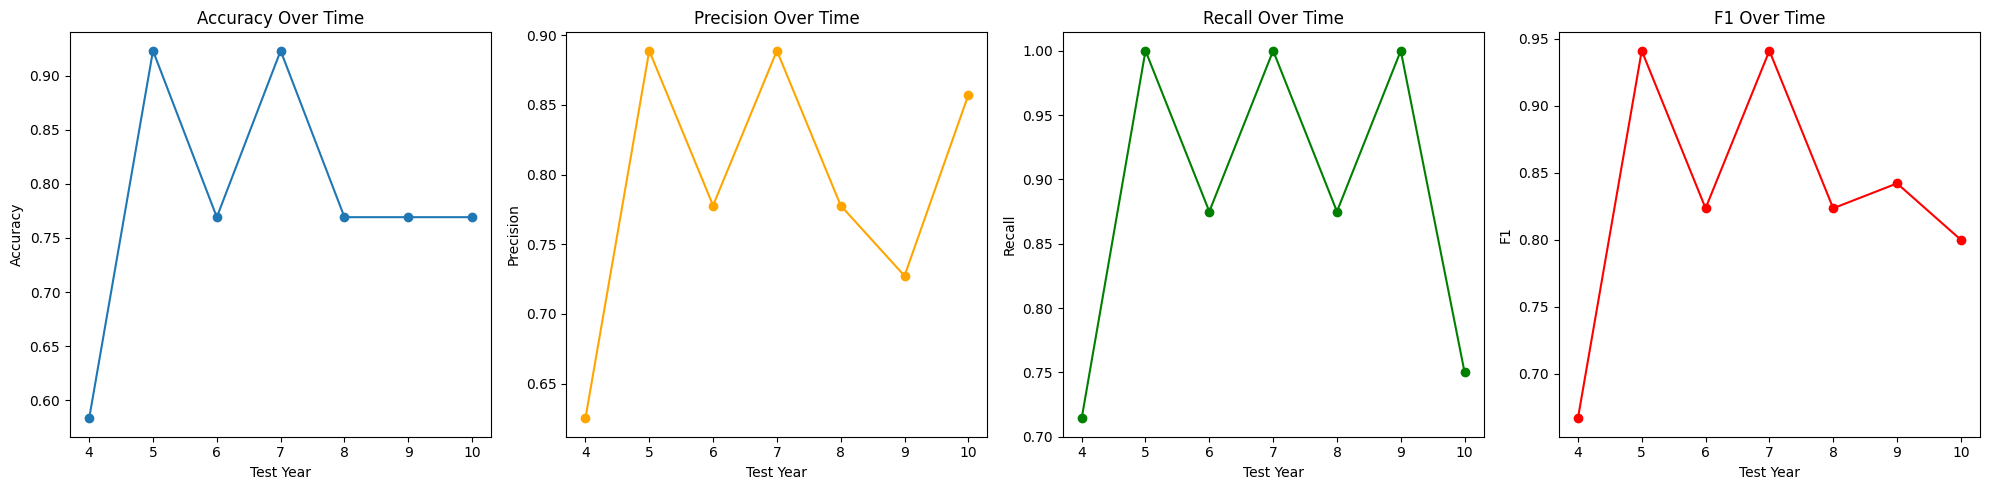

In [35]:
model = DecisionTreeClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams)
accuracy, precision, recall, f1 = train_evaluate_decision_tree(model, df_teams)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

[1 1 0 1 0 1 0 1 1 0 1 1]
[1 1 1 1 0 1 1 0 1 1 1 0 1]
[0 1 1 0 1 1 1 1 1 1 1 1 0]
[1 1 0 1 0 0 0 1 1 1 1 1 0]
[1 0 1 0 0 0 1 1 0 1 1 0 0]
[0 1 1 0 1 1 1 1 0 1 1 0 1]
[1 0 1 0 0 1 1 0 0 0 1 1 0]
Accuracy: 0.8
Precision: 0.7755102040816326
Recall: 0.95
F1: 0.8539325842696629


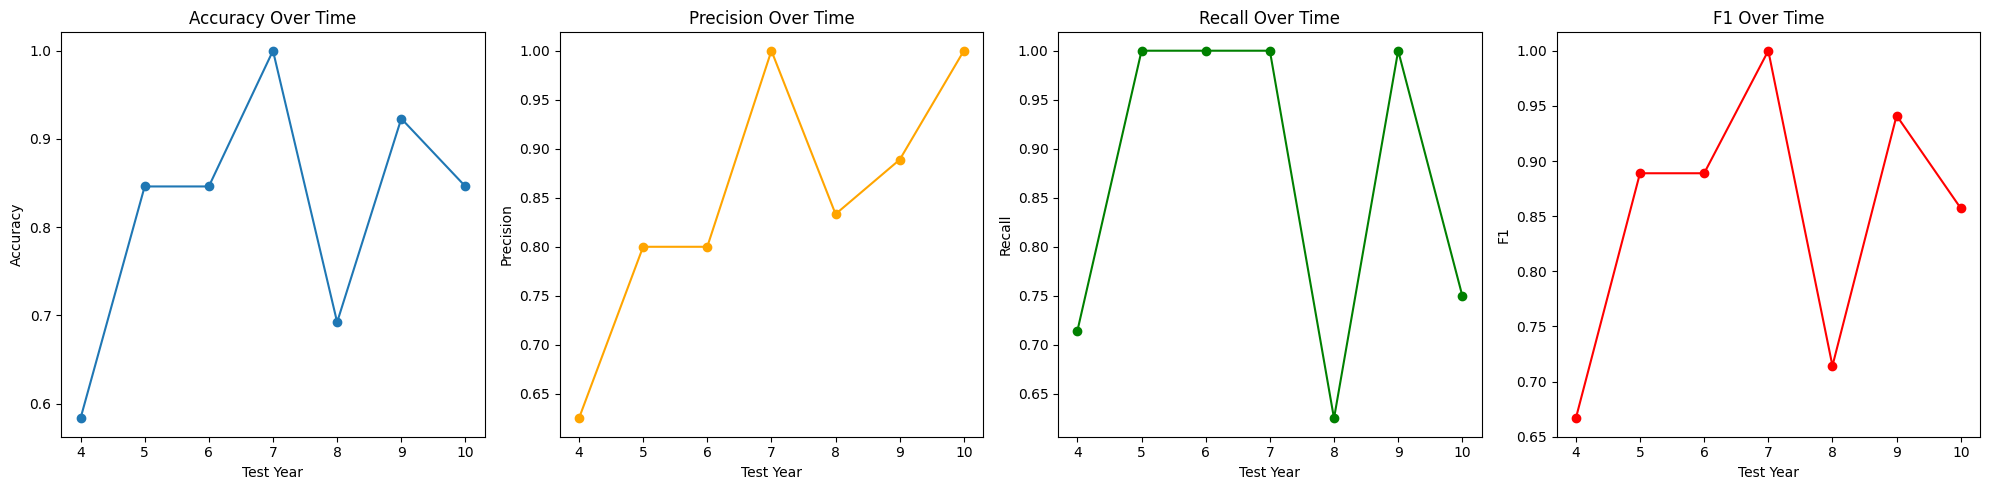

In [36]:
model = RandomForestClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams)
accuracy, precision, recall, f1 = train_evaluate_decision_tree(model, df_teams)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

[0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1.]
[1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1.]
[0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0.]
[1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0.]
[1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1.]
[0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1.]
[1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0.]
Accuracy: 0.676923076923077
Precision: 0.6792452830188679
Recall: 0.9
F1: 0.7741935483870968


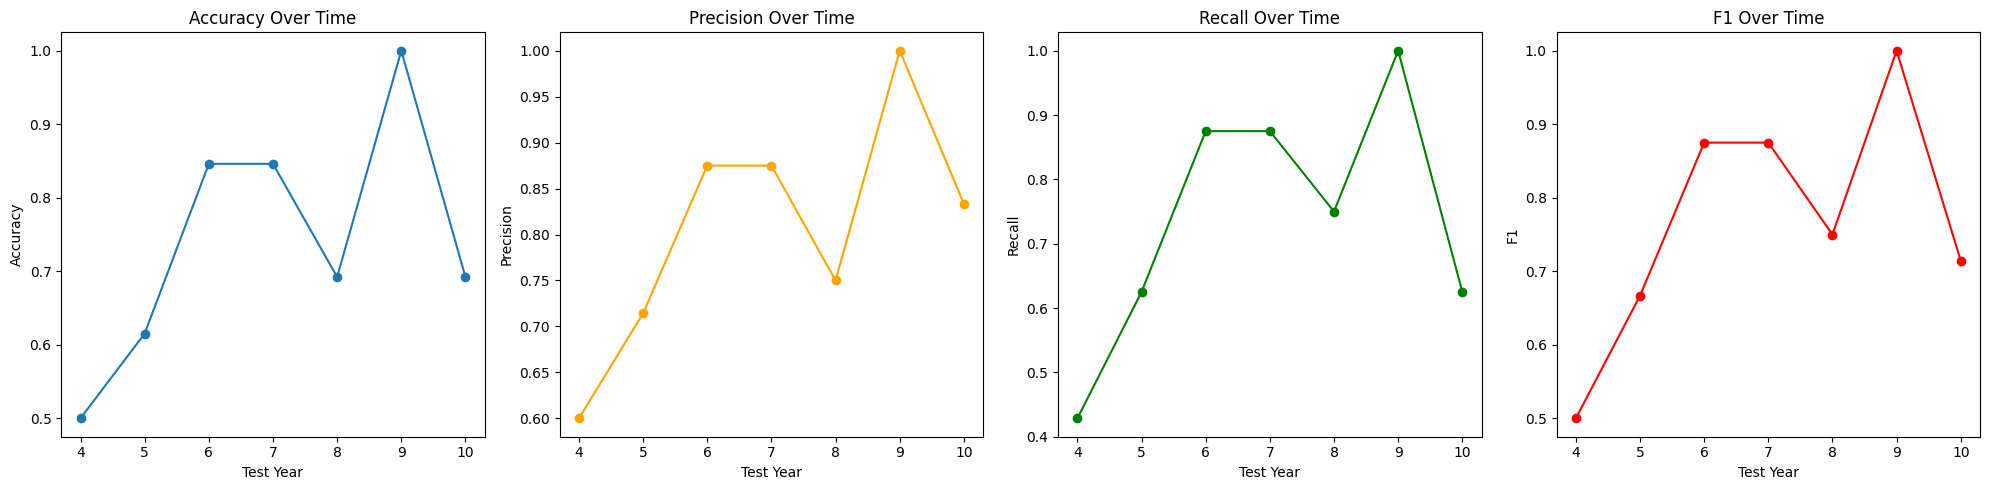

In [37]:
model = KNeighborsClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True)
accuracy, precision, recall, f1 = train_evaluate_decision_tree(model, df_teams, scaling=True)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

[0 1 0 1 0 1 1 1 1 1 1 1]
[1 1 1 1 0 1 1 0 1 1 1 1 1]
[0 0 1 0 1 1 1 1 0 0 1 1 0]
[1 1 0 1 1 0 0 1 1 1 1 1 0]
[1 0 0 0 1 0 1 1 0 1 1 0 0]
[0 1 1 1 1 0 1 1 0 1 1 0 1]
[1 0 1 0 0 1 1 0 0 0 1 1 0]
Accuracy: 0.9076923076923077
Precision: 0.9473684210526315
Recall: 0.9
F1: 0.9230769230769231


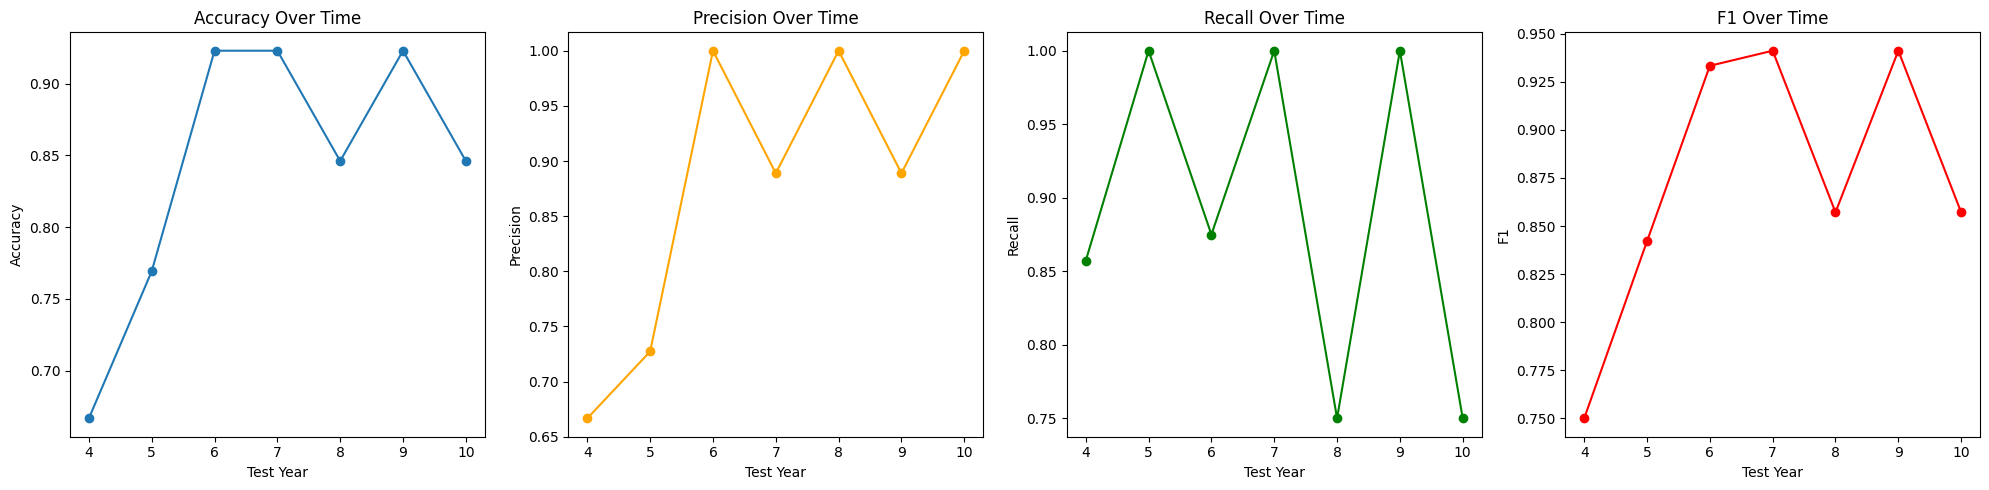

In [38]:
model = XGBClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams)
accuracy, precision, recall, f1 = train_evaluate_decision_tree(model, df_teams)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)


[0 0 0 1 0 1 0 1 0 0 1 1]
[1 1 1 0 0 0 0 0 1 1 1 0 1]
[0 1 1 0 1 1 1 1 0 0 1 1 0]
[0 1 0 1 0 0 0 1 0 0 1 1 0]
[1 0 1 1 0 0 1 1 1 1 1 0 1]
[1 1 1 1 0 0 1 1 1 1 1 0 1]
[1 1 1 0 0 1 1 1 0 0 1 1 0]
Accuracy: 0.7076923076923077
Precision: 0.6981132075471698
Recall: 0.925
F1: 0.7956989247311829


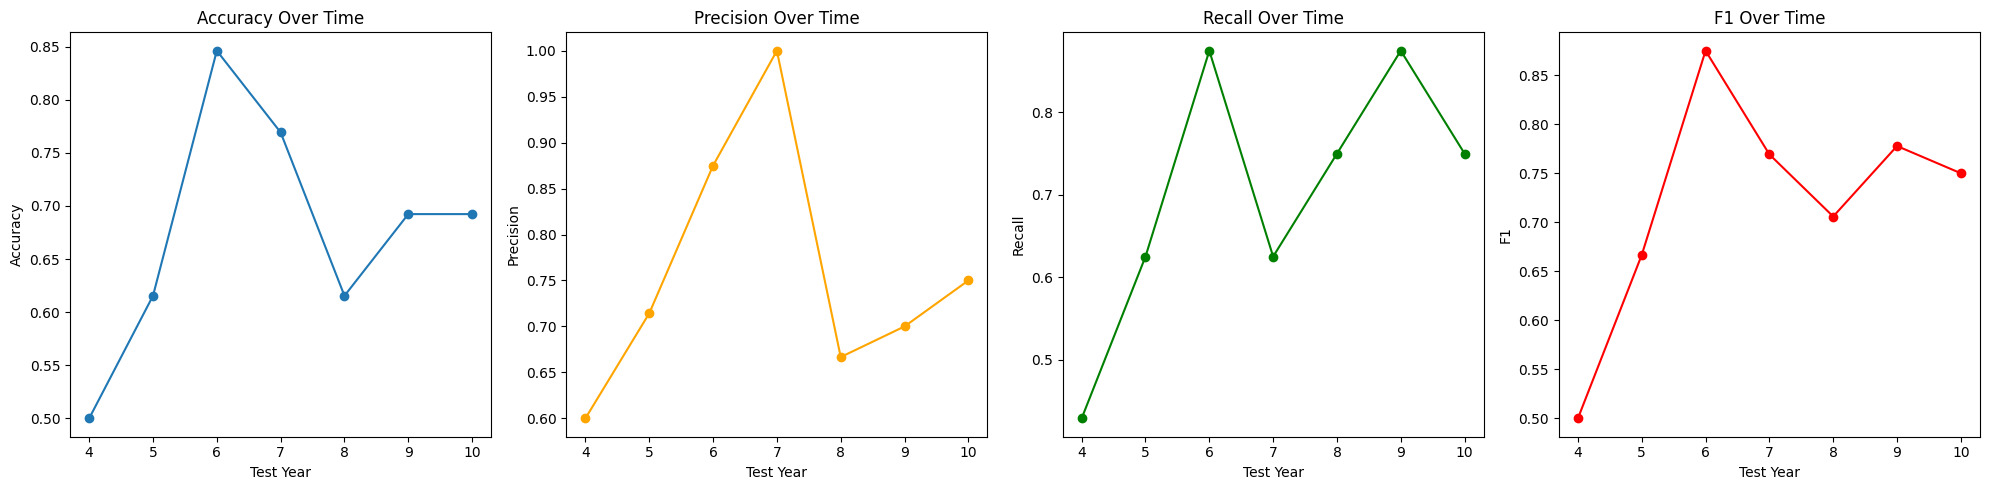

In [39]:
model = GaussianNB()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams)
accuracy, precision, recall, f1 = train_evaluate_decision_tree(model, df_teams)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

[0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1.]
[1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1.]
[0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0.]
[1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0.]
[1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.]
[0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1.]
[1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0.]
Accuracy: 0.6461538461538462
Precision: 0.639344262295082
Recall: 0.975
F1: 0.7722772277227722


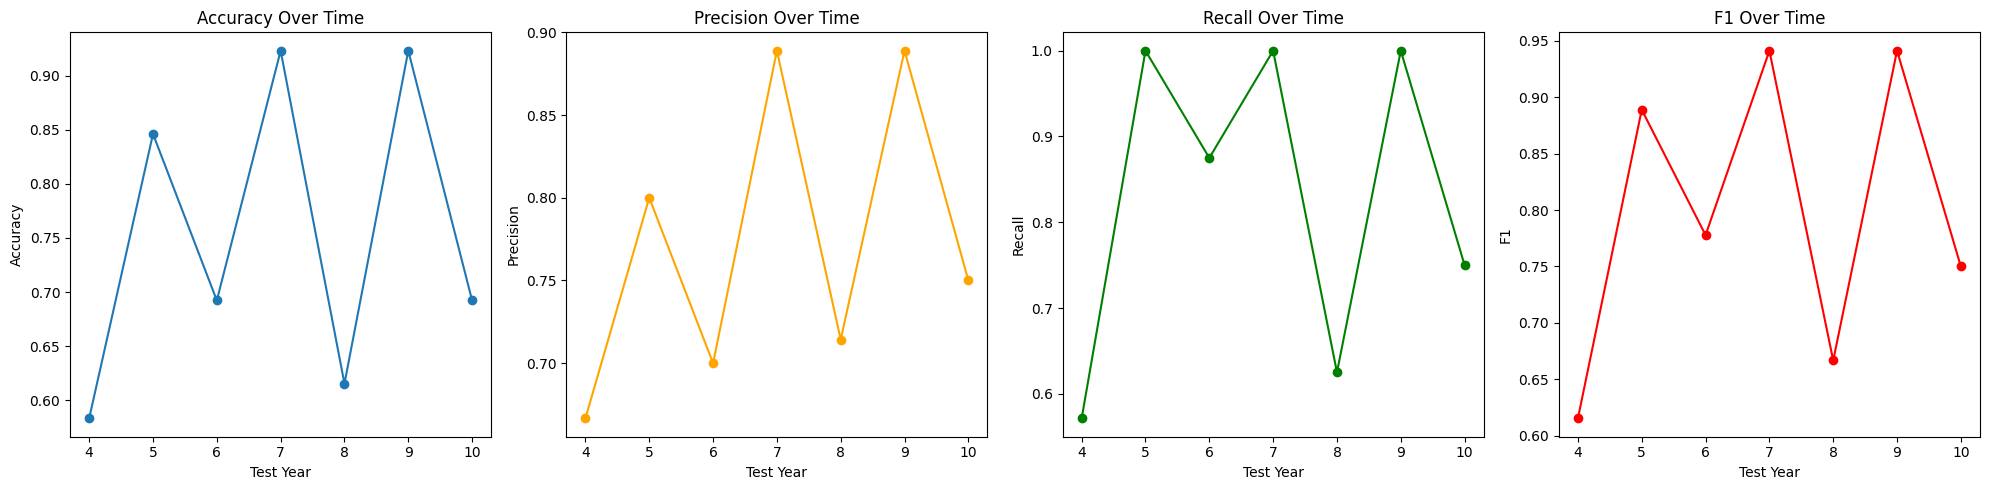

In [40]:
model =SVC()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True)
accuracy, precision, recall, f1 = train_evaluate_decision_tree(model, df_teams, scaling=True)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

[0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1.]
[0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0.]
[1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0.]
[1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0.]
[0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1.]
[1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0.]
Accuracy: 0.8769230769230769
Precision: 1.0
Recall: 0.8
F1: 0.888888888888889


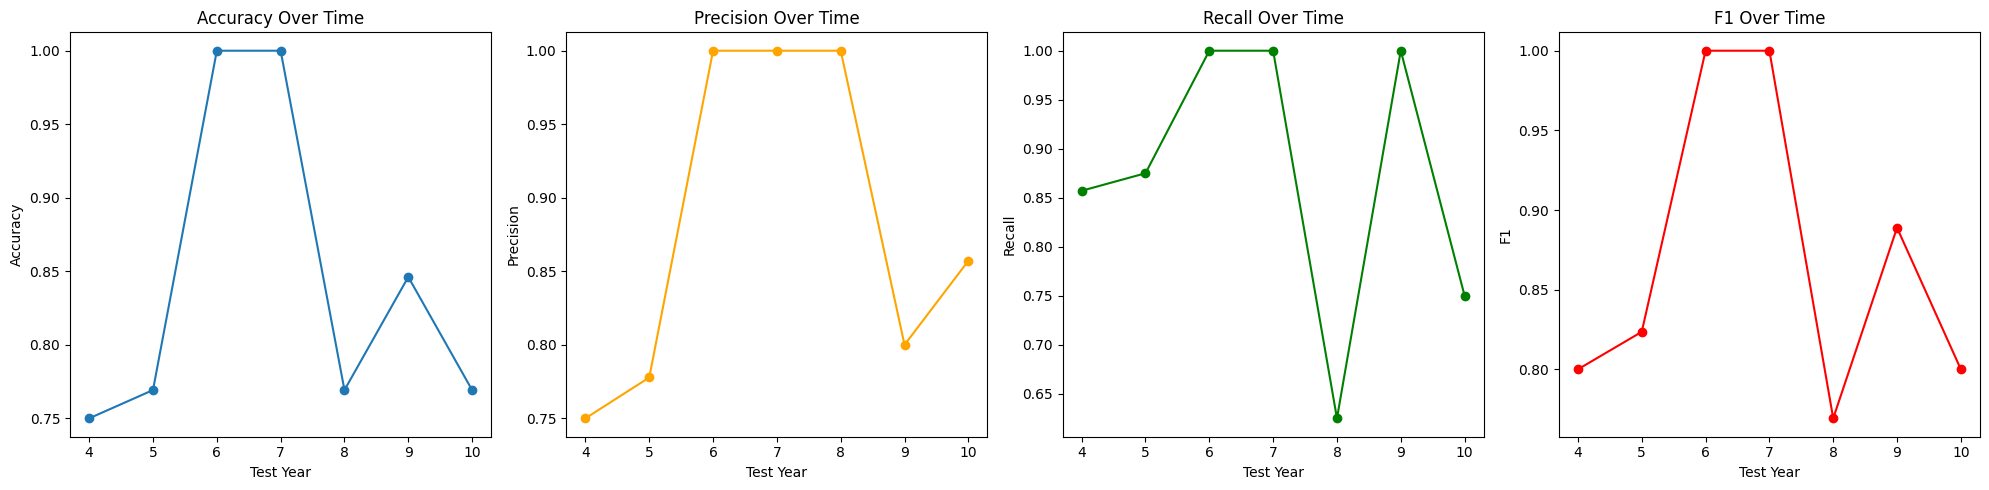

In [41]:
model = LogisticRegression()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True)
accuracy, precision, recall, f1 = train_evaluate_decision_tree(model, df_teams, scaling=True)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1.]


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0.]
[1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 0.]


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0.]


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1.]


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0.]
Accuracy: 0.8153846153846154
Precision: 0.8888888888888888
Recall: 0.8
F1: 0.8421052631578948


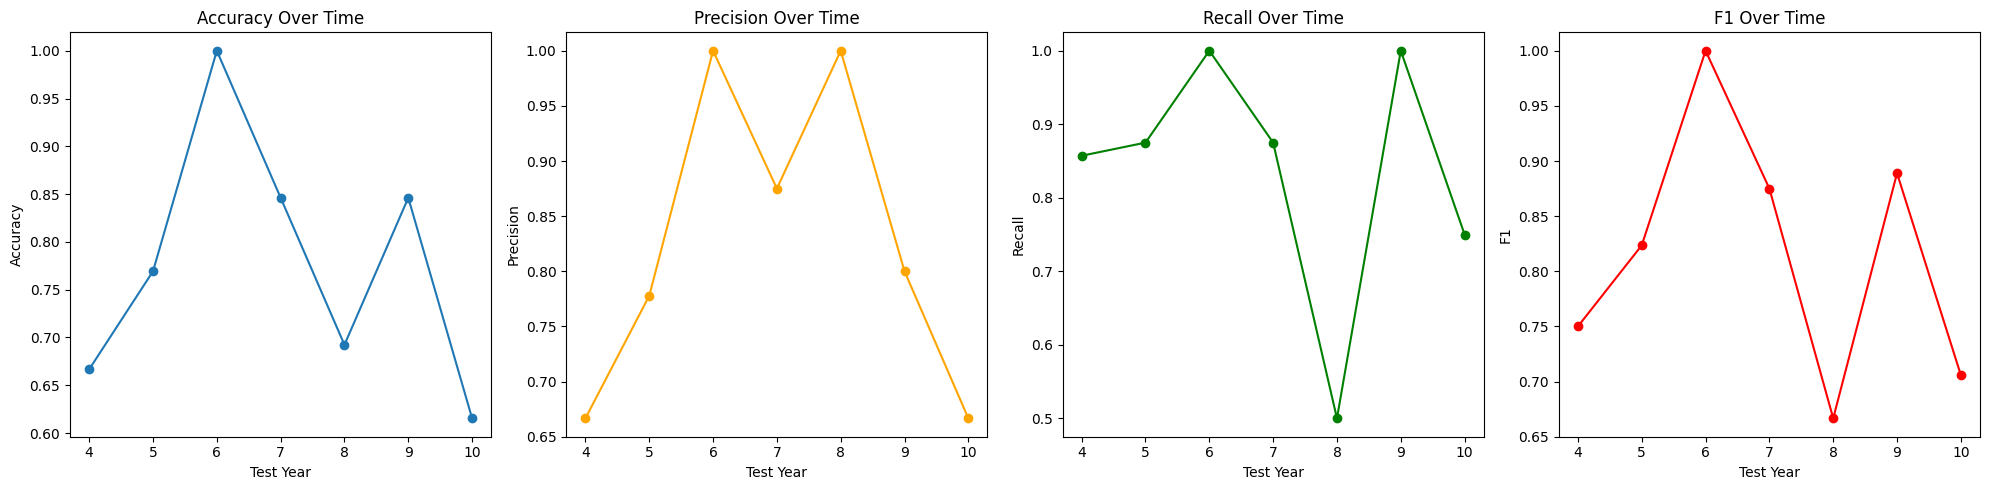

In [42]:
model = MLPClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams, scaling=True)
accuracy, precision, recall, f1 = train_evaluate_decision_tree(model, df_teams, scaling=True)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)